In [1]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
notebooks = os.path.abspath('')
src = os.path.dirname(notebooks)
if not src in sys.path: 
    sys.path.append(src)

In [3]:
from helpers import get_emotion_abrs_from_ids

# Paths

In [4]:
output_path = '../../files/out/video/'
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [5]:
exec(open(glob_conf_path).read())

# Parameters

In [6]:
threads = -10

# Load and shuffle data

In [7]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id,group
2390,A201_sad_p_3,0.085853,0.347717,0.0,0.05,0.068548,0.068548,0.144231,0.099202,0.286747,...,0.479884,0.206857,0.0,0.000000,0.408359,0.408359,0.099010,A201,6,3
2146,A201_bor_v_3,0.409475,0.199905,0.0,0.00,0.368548,0.368548,0.096154,0.141613,0.256958,...,0.234310,0.369600,0.0,0.000000,0.087070,0.087070,0.039604,A201,26,3
9213,A65_nos_p_2,0.058515,0.596365,0.0,0.15,0.016129,0.016129,0.067308,0.055337,0.258642,...,0.050793,0.253234,0.0,0.111111,0.030475,0.030475,0.099010,A65,30,4
5516,A26_reg_v_1,0.106750,0.376186,0.0,0.15,0.072581,0.072581,0.105769,0.112120,0.368763,...,0.631815,0.195240,0.0,0.000000,0.568132,0.568132,0.079208,A26,0,1
10588,A75_nos_p_4,0.117903,0.514505,0.0,0.10,0.030645,0.030645,0.009615,0.137451,0.312158,...,0.088909,0.230322,0.0,0.111111,0.082717,0.082717,0.049505,A75,30,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,A334_neu_sit3_v,0.022987,0.384122,0.0,0.05,0.012097,0.012097,0.144231,0.022790,0.264834,...,0.238276,0.308160,0.0,0.000000,0.093165,0.093165,0.069307,A334,22,10
4848,A223_sar_v_1,0.085952,0.370207,0.0,0.05,0.070565,0.070565,0.211538,0.030387,0.303431,...,0.120496,0.706075,0.0,0.055556,0.023944,0.023944,0.079208,A223,31,10
3912,A220_conf_v_1,0.020227,0.148694,0.0,0.20,0.014113,0.014113,0.105769,0.046551,0.180510,...,0.016536,0.149081,0.0,0.083333,0.017414,0.017414,0.079208,A220,1,11
3768,A21_reg_v_1,0.066944,0.245488,0.0,0.00,0.050403,0.050403,0.086538,0.066539,0.320183,...,0.027456,0.205459,0.0,0.111111,0.018285,0.018285,0.099010,A21,0,5


# Other functions

In [8]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [9]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [10]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [11]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [12]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Training and testing

### Get X, y and groups from the training data set

In [13]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

# Elastic Net SGD Classifier

### Cross validate with best parameters

[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.
[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:  1.1min finished
[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.


printing Area Under the Curve (AUC) measures
AUC_avg (train): 0.7830641444721862
AUC_std (train): 0.00217714891082647
AUC_avg (validation): 0.7584059816819695
AUC_std (validation): 0.032127956757576195


[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:  1.0min finished


printing Unweighted Average Recall (UAC) measures
UAR_avg (train): 0.1363379019145208
UAR_std (train): 0.0022490180400071133
UAR_avg (validation): 0.10144597654824442
UAR_std (validation): 0.02355236569067908


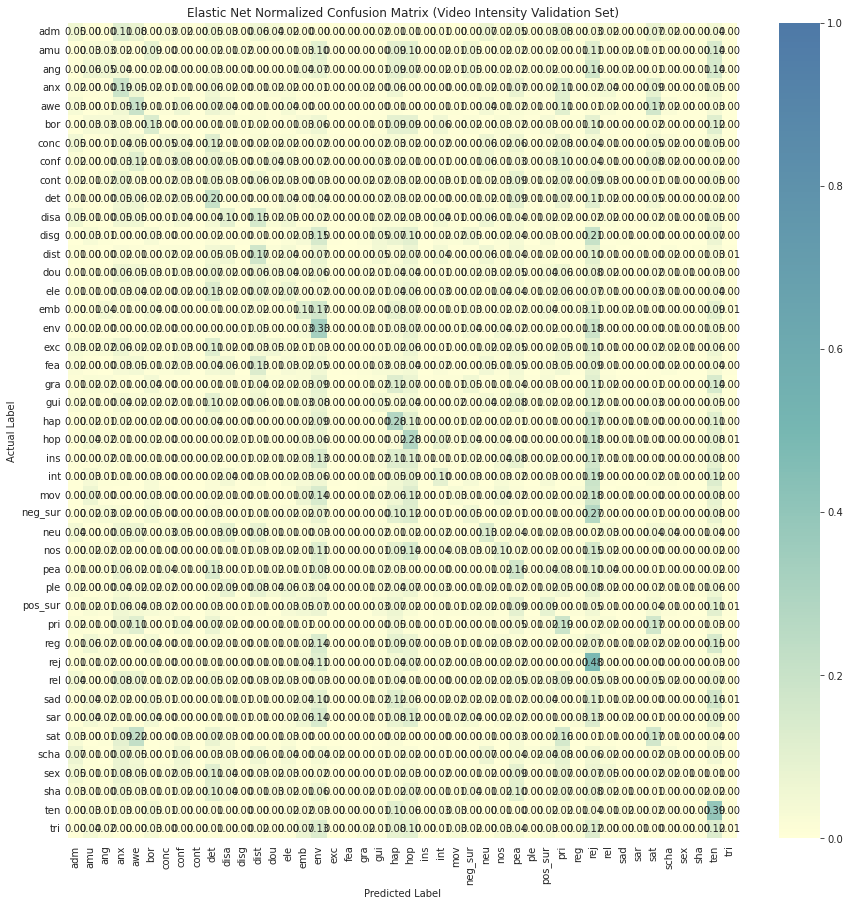

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

logo = LeaveOneGroupOut()

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

# get scores
scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('printing Area Under the Curve (AUC) measures')
print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True
                       )
      
print('printing Unweighted Average Recall (UAC) measures')
print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_intensity_video.svg')


# kNN Classifier

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.
[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:   41.7s remaining:   41.7s
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:   42.3s finished
[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.


AUC_avg (train): 0.7544569192927912
AUC_std (train): 0.0025297133713038057
AUC_avg (validation): 0.7369199050025909
AUC_std (validation): 0.03746768964957706


[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:   26.8s remaining:   26.8s
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:   27.2s finished


UAR_avg (train): 0.09849033785051146
UAR_std (train): 0.0014296821048657914
UAR_avg (validation): 0.08516803680732912
UAR_std (validation): 0.022618948318586237


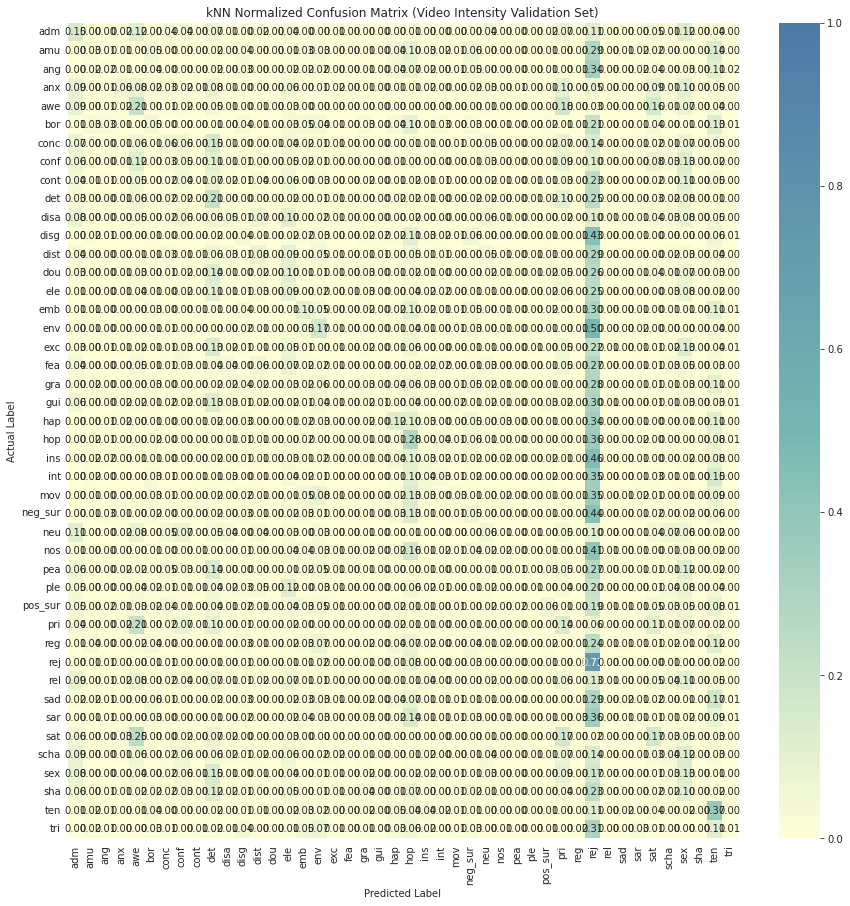

In [15]:
from sklearn.neighbors import KNeighborsClassifier


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))

clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='kNN Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_knn_intensity_video.svg')

## Decision Tree


[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.
[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:    3.6s finished
[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.


AUC_avg (train): 0.6917927995029424
AUC_std (train): 0.0020922007956643584
AUC_avg (validation): 0.6855048570566945
AUC_std (validation): 0.030398841702019775


[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:    0.3s finished


UAR_avg (train): 0.0637034698045742
UAR_std (train): 0.0010567749545203234
UAR_avg (validation): 0.05932095374782309
UAR_std (validation): 0.012806385928534133


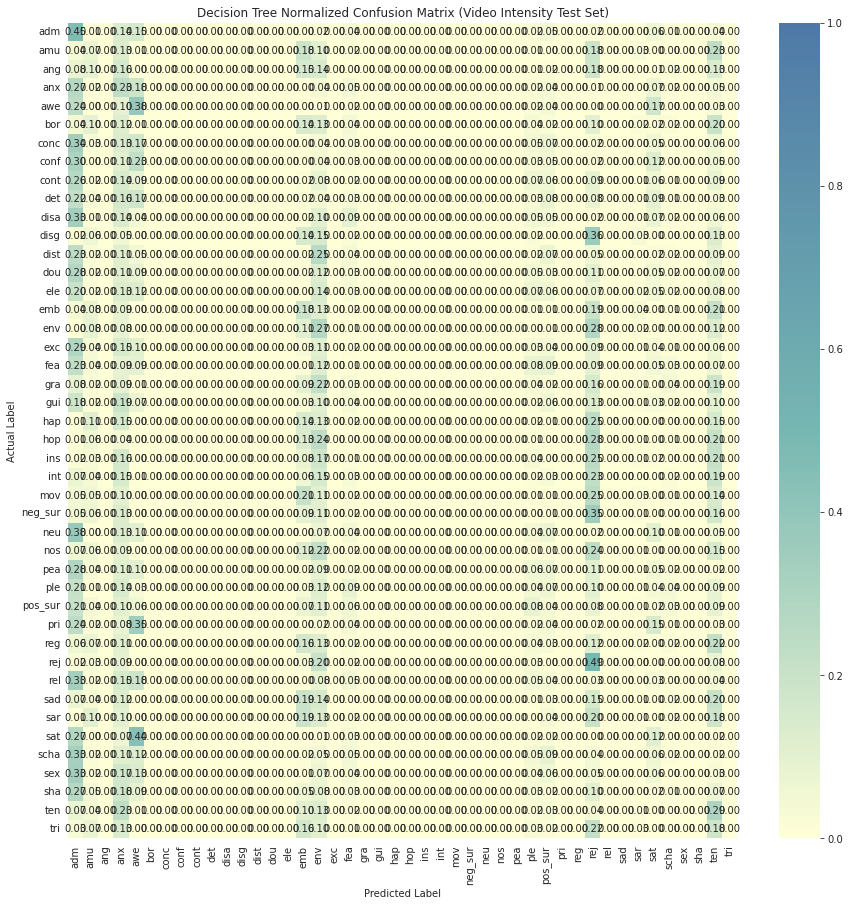

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Decision Tree Normalized Confusion Matrix (Video Intensity Test Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_tree_intensity_video.svg')

# Random Forrest

[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.
[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:   28.3s remaining:   28.3s
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:   28.6s finished
[Parallel(n_jobs=-10)]: Using backend LokyBackend with 43 concurrent workers.


AUC_avg (train): 0.9837461565228929
AUC_std (train): 0.0005621552497455342
AUC_avg (validation): 0.7469379051645155
AUC_std (validation): 0.03573824894415437


[Parallel(n_jobs=-10)]: Done   8 out of  16 | elapsed:   25.3s remaining:   25.3s
[Parallel(n_jobs=-10)]: Done  16 out of  16 | elapsed:   26.1s finished


UAR_avg (train): 0.7956871619483694
UAR_std (train): 0.004805048388135836
UAR_avg (validation): 0.09333730883185129
UAR_std (validation): 0.02133008165392025


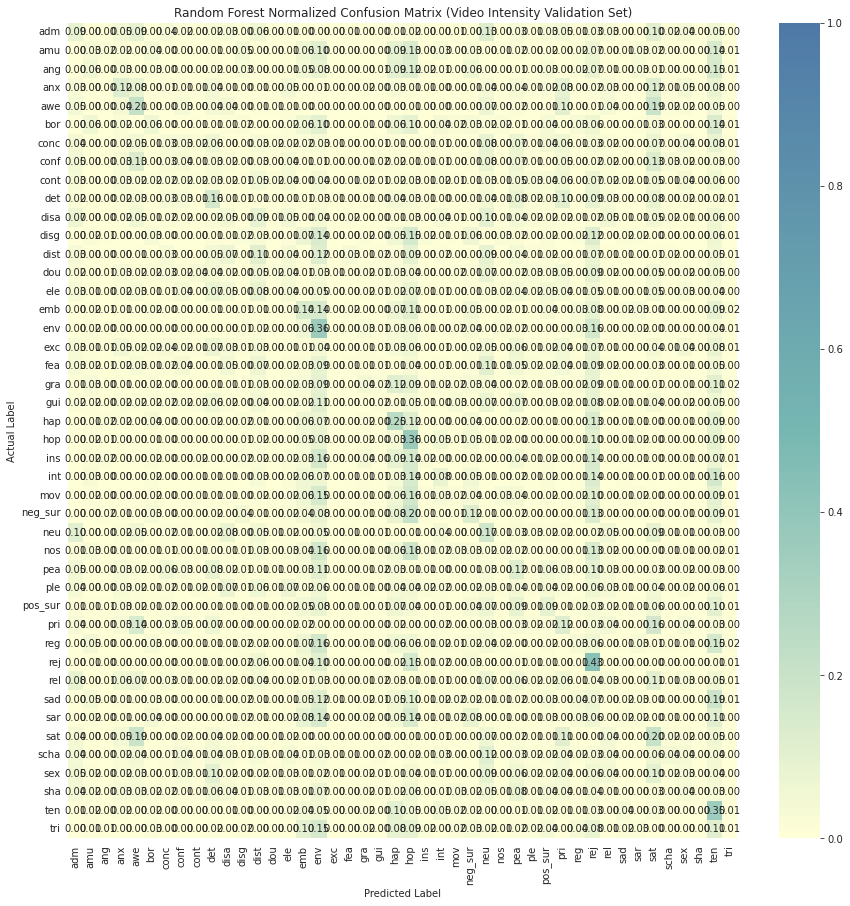

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_intensity_video.svg')